In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from functools import partial
# from funcy import compose
compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy.stats import wilcoxon
from numpy.fft import fft, ifft, fftfreq

from best_subset import *
from solvel0 import solvel0
from UBIC import fit_blr, UBIC, decreasing_values_indices
from para_UBIC import *

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.random import sample_without_replacement
# https://github.com/Pongpisit-Thanasutives/OKRidge
from okridge.solvel0 import okridge_solvel0, okridge_solvel0_full
from findiff import FinDiff

import sys; sys.path.append('/Users/pongpisit/Documents/github/ICOMP/')
from icomp_lm import *

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs, epsilon=1e-5):
    nobs2 = nobs / 2.0
    # llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    llf = -nobs2*np.log(2*np.pi*ssr/nobs+epsilon)
    return llf

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    # llf = ssr2llf(rss, nobs, epsilon)
    # return -2*llf + np.log(nobs)*nparams
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord='fro')**2 
    # llf = -(N/2)*np.log(2*np.pi*rss/N+epsilon)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # return -2*llf + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)
fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2


In [2]:
def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return np.array(Theta_grouped), np.array(Ut_grouped)

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    normalized_As = As.copy()
    normalized_bs = bs.copy()
    # normalize
    for i in range(m):
        normalized_As[i] = normalized_As[i].dot(np.diag(candidate_norms**-1))
        normalized_bs[i] = normalized_bs[i]/norm_bs[i]
        
    return normalized_As, normalized_bs

def remove_f(uu, percent):
    if percent <= 0: return uu
    PSD = (uu*np.conj(uu))/np.prod(uu.shape)
    PSD = PSD.real
    mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
    return uu*mask

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

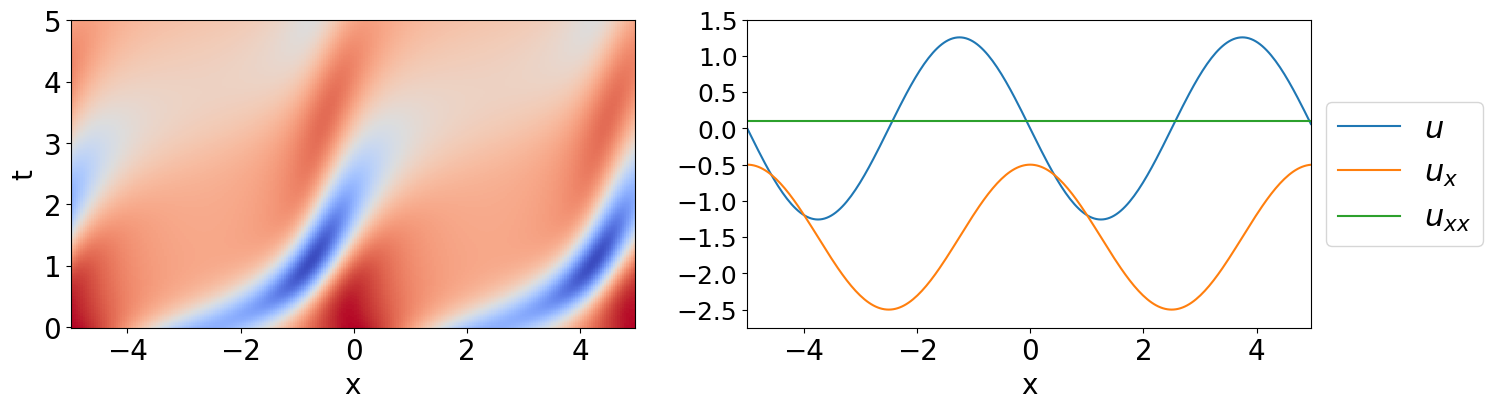

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
show()
# fig.tight_layout()

In [5]:
noise_lv = 2
noise_lv = abs(noise_lv)
u_clean = u.copy()
u = u + 0.01*noise_lv*std(u)*np.random.randn(*u.shape)

In [6]:
is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    # equivalent to np.hstack([savgol_filter(u[:, i], window_size, poly_order).reshape(-1, 1) for i in range(u.shape[-1])])
    u = savgol_filter(u, window_size, poly_order, axis=0)

In [7]:
# Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, 
#                                          time_diff = 'FD', space_diff = 'Fourier')
alpha = 3e-4 # 1e-3 (ok for pysr env. but not ok for pysindy_latest env.)
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                        diff_kwargs, 
                                                                        include_bias=False)
# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "spatial")

fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

# physics is such fundamental that it can be discovered from in low-freq data (validation set)
# fft_percent = 90
# acc = 8
# d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(u)
# d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(u)
# d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(u)
# d_dt = FinDiff(1, dt, 1, acc=acc); u_t = d_dt(u)
    
# phi1 = [u**i for i in range(0, 4)]; phi1_names = ["", "u", "u^{2}", "u^{3}"]
# phi2 = [u_x, u_xx, u_xxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}"]
# phi = phi1.copy(); phi_names = phi1_names.copy()
# phi.extend([p1*p2 for p1 in phi1 for p2 in phi2])
# phi = np.array(phi)
# phi_names.extend([p1+p2 for p1 in phi1_names for p2 in phi2_names])
# fft_phi = [remove_f(fft(_), fft_percent) for _ in phi]
# fft_u_t = remove_f(fft(u_t), fft_percent)

# Theta_grouped = np.moveaxis(phi, 0, -1)
# Ut_grouped = np.expand_dims(u_t, -1)
# rhs_des = phi_names
# fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
# fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

# del phi1, phi2, phi1_names, phi2_names

0 u
3 u_x
4 u_xx


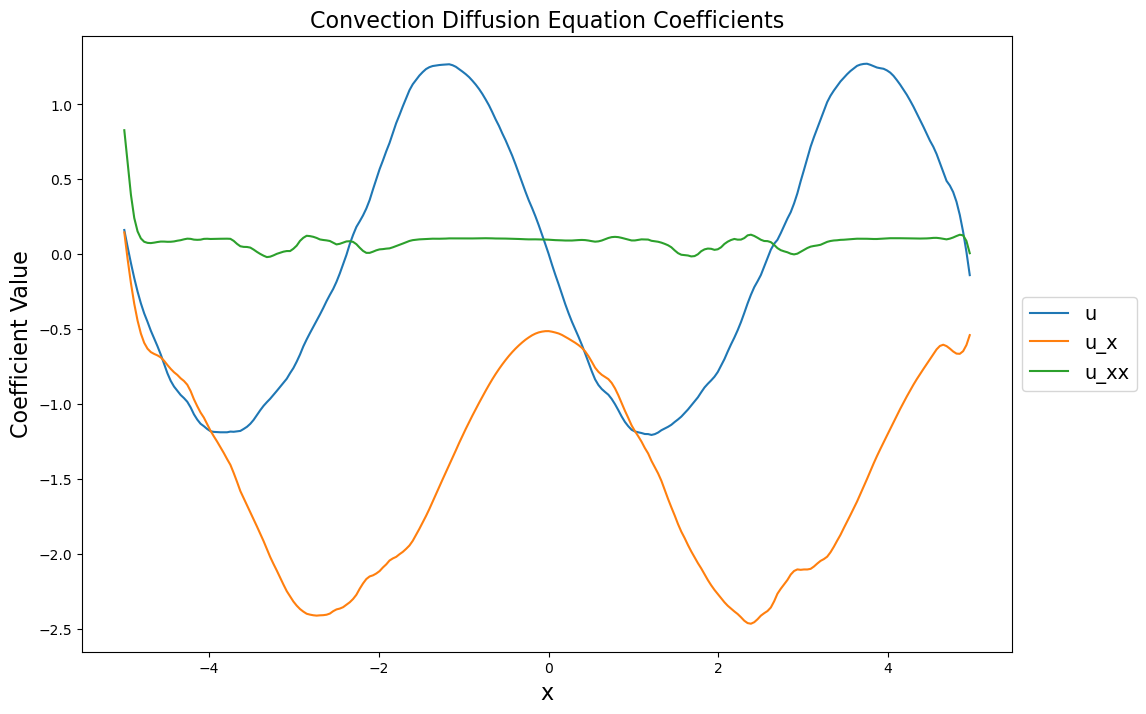

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [9]:
true_xi = np.vstack((u_true, u_x_true, u_xx_true))
errors = xi[np.where(np.linalg.norm(xi, axis=1))[0]]-true_xi
errors = 100*np.linalg.norm(errors, axis=1)/np.linalg.norm(true_xi, axis=1)
errors.mean(), errors.std()

(29.079353901690983, 30.194315231511716)

In [10]:
max_complexity = 10
candidates = [[] for _ in range(max_complexity)]
for i in trange(len(Theta_grouped)):
    candidates_i = sorted(set(solvel0(Theta_grouped[i], Ut_grouped[i], max_complexity=max_complexity, 
                                      miosr=True, refine=True, verbose=False)), key=len)
    for i in range(max_complexity):
        candidates[i].append(candidates_i[i])
candidates   

  0%|                                                                                                   | 0/256 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|█████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:50<00:00,  2.31it/s]


[[(5,),
  (4,),
  (4,),
  (4,),
  (5,),
  (5,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (4,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),


3 1 3


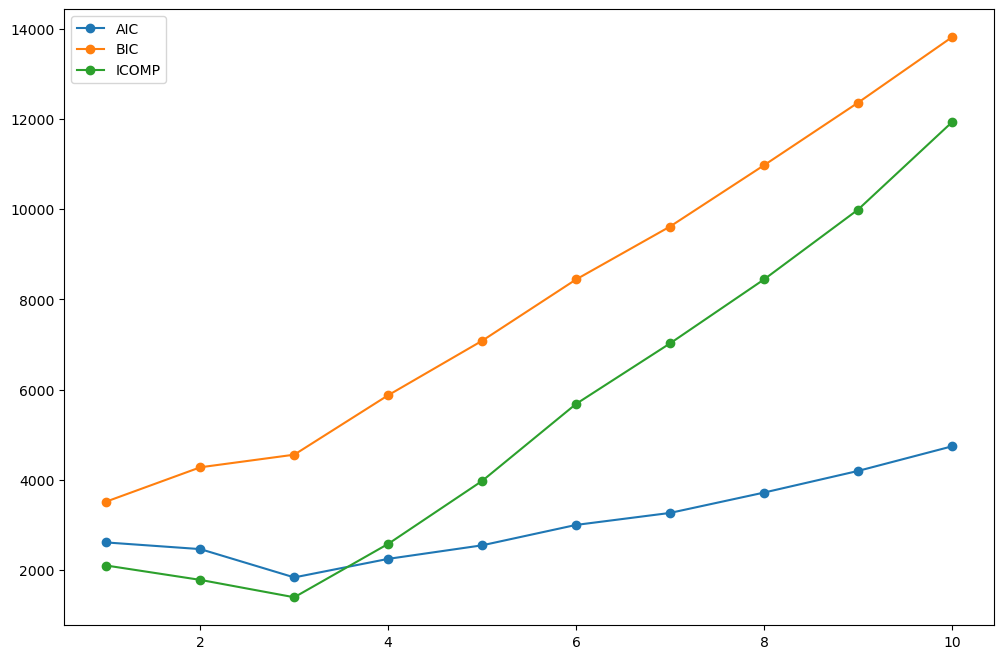

In [11]:
# from scipy import linalg as splinalg
# from scipy.sparse import csc_array, csc_matrix
# from scipy.sparse import linalg as splin

# for indices in sorted(candidates, key=len):
#     theta_b = csc_matrix(splinalg.block_diag(*[Theta_grouped[j][:, indices] for j in range(len(Theta_grouped))]), dtype=float)
#     ut_b = Ut_grouped.reshape(-1, 1)
#     xi_b = splin.lsqr(theta_b, ut_b)[0].reshape(-1, 1)
#     rss = np.sum((ut_b-theta_b@xi_b)**2)
#     print(len(indices), rss2bic(rss, np.count_nonzero(xi_b), len(ut_b)))
#     break

# time_integrator = lambda _: _
# time_integrator = partial(trapz, axis=1)
time_integrator = compose(partial(trapz, axis=1), 
                          lambda _ : periodogram(_, return_onesided=False, axis=1)[1])
epsilon = 0
ic_scores = {}
ICOMPs = []; a_n = 1
AICs = []
BICs = []
for candidate in candidates:
    CMs = []
    k = 0
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[candidate[j], j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, candidate[j]], Ut_grouped[j], rcond=None)[0]
        _, CM, _ = llf_complexity(Theta_grouped[j][:, candidate[j]], Ut_grouped[j], a_n=None)
        CMs.append(CM[1])
        k += len(candidate[j])

    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    # N = np.prod(Ut_grouped.shape)
    N = np.prod(time_integrator(Ut_grouped).shape)
    
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    # bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    aic = N*np.log(2*np.pi*rss/N+epsilon) + 2*k
    bic = N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k
    icomp = N*np.log(2*np.pi*rss/N+epsilon) + 2*a_n*np.sum(CMs)
    AICs.append(aic)
    BICs.append(bic)
    ICOMPs.append(icomp)

print(np.argmin(AICs)+1, np.argmin(BICs)+1, np.argmin(ICOMPs)+1)
plt.plot([_+1 for _ in range(max_complexity)], AICs, '-o', label='AIC')
plt.plot([_+1 for _ in range(max_complexity)], BICs, '-o', label='BIC')
plt.plot([_+1 for _ in range(max_complexity)], ICOMPs, '-o', label='ICOMP')
plt.legend()
plt.show()

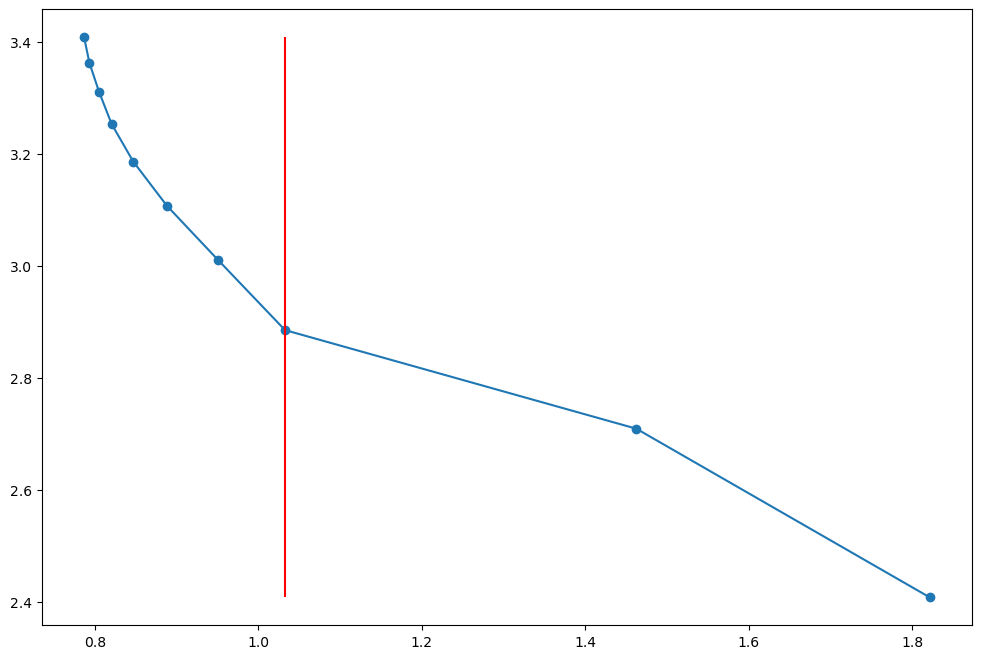

In [12]:
log_errors = []
log_coms = []
for candidate in candidates:
    com = 0
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = SkLinearRegression(fit_intercept=False).fit(Theta_grouped[j][:, candidate[j]], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = Ut_grouped[j] - Theta_grouped[j][:, candidate[j]].dot(est_xi)
        rss += np.sum(difference**2)
        com += len(candidate[j])
    log_error = np.log10(np.sqrt(rss))
    log_com = np.log10(com)
    log_errors.append(log_error)
    log_coms.append(log_com)
plt.plot(log_errors, log_coms, '-o')
plt.vlines(find_corner(log_errors, log_coms), ymin=min(log_coms), ymax=max(log_coms), color='red')
plt.show()

## PDE Uncertainty

In [13]:
best_subsets = {}
for com, candidate in enumerate(candidates):
    com = com + 1
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):
        # model = BayesianRidge(fit_intercept=False)
        model = ARDRegression(fit_intercept=False)
        model.fit(Theta_grouped[j][:, candidate[j]], Ut_grouped[j])
        
        post_prediction = (fft_Theta_grouped[j][:, candidate[j]]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction)**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if com not in best_subsets: best_subsets[com] = (rss, uncert, indices)
    elif rss < best_subsets[com][0]: best_subsets[com] = (rss, uncert, indices)
        
min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
complexities = sorted(best_subsets.keys())
uncertainties = []
for com in complexities:
    _, uncert, _ = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
uncertainties = np.array(uncertainties)

100%|████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 392.49it/s]


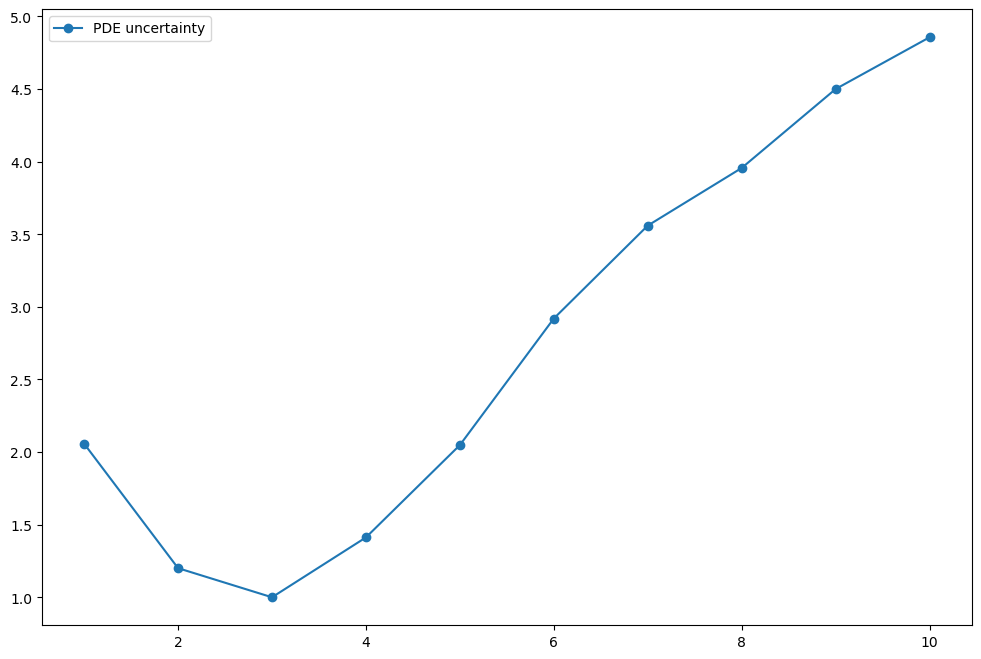

In [14]:
plt.plot([_+1 for _ in range(max_complexity)], uncertainties, '-o', label='PDE uncertainty')
plt.legend()
plt.show()

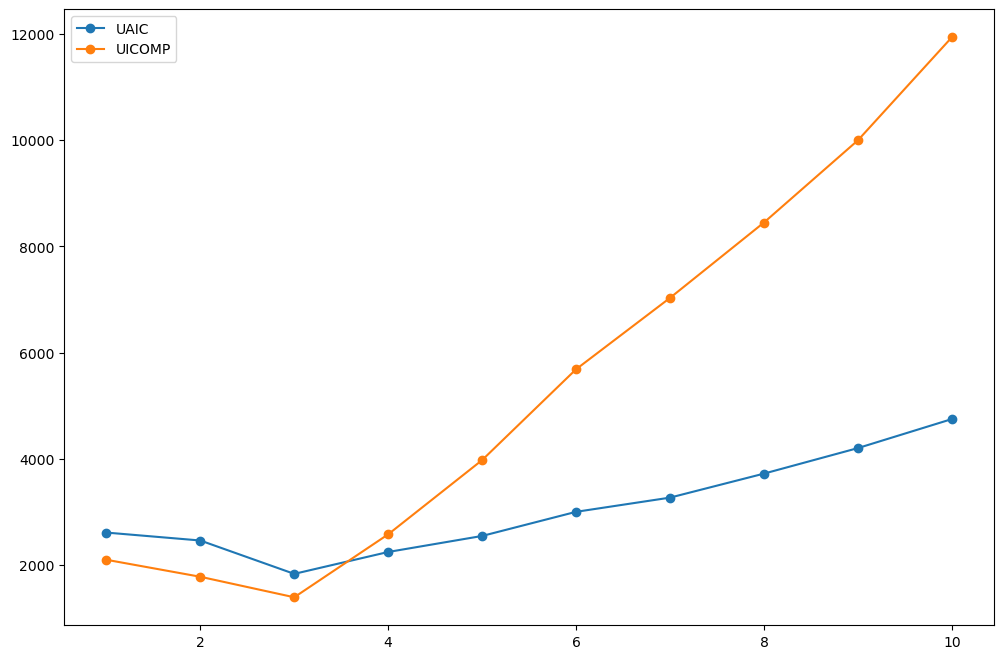

In [15]:
plt.plot([_+1 for _ in range(max_complexity)], np.array(AICs)+2*uncertainties, '-o', label='UAIC')
plt.plot([_+1 for _ in range(max_complexity)], np.array(ICOMPs)+2*a_n*uncertainties, '-o', label='UICOMP')
plt.legend()
plt.show()